In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import numpy as np 
import gc
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('D:/train_gini.csv')
df.rename({'0': 'pred_0', '1':'pred'}, axis = 1, inplace = True)
df.head()

#df = pd.DataFrame({'target': np.random.randint(2, size=5000),'pred' : np.random.rand(5000)})
#np.bincount(np.random.randint(2, size=5000))

,pred_0,pred,target
0,0.864241,0.135759,0
1,0.652397,0.347603,0
2,0.661938,0.338062,0
3,0.877545,0.122455,0
4,0.842193,0.157807,0


In [22]:
def gini(data,target,prediction,bin=10):
    qnt = np.quantile(data[prediction],q=np.linspace(0, 1, bin+1),axis=0)
    qnt[0] = -0.001
    qnt[bin] = 1
    data['band'] = pd.cut(data[prediction], qnt)
    gini_tab = pd.crosstab(index=data['band'],columns=data[target],margins=True, margins_name="Total",\
            rownames=['band'], colnames=['index'])
    gini_tab.reset_index(inplace=True)
    gini_tab.rename({1 : 'Event' , 0 : 'NonEvent'},axis = 1,inplace=True)
    gini_tab_tot = gini_tab.loc[bin]
    gini_tab = gini_tab.drop(bin)[::-1]
    gini_tab.loc[bin] = gini_tab_tot
    gini_tab.reset_index(drop= True, inplace = True)
    gini_tab['cum_nonevent'] = gini_tab.NonEvent.cumsum()
    gini_tab.loc[bin,'cum_nonevent'] = gini_tab.loc[bin, 'NonEvent']

    gini_tab['cum_event'] = gini_tab.Event.cumsum()
    gini_tab.loc[bin,'cum_event'] = gini_tab.loc[bin, 'Event']
    
    gini_tab['population_%'] = 100*(gini_tab['Total']/gini_tab.loc[bin,'Total'])
    gini_tab['cum_nonevent_%'] = 100*(gini_tab['cum_nonevent']/gini_tab.loc[bin,'NonEvent'])
    gini_tab['cum_event_%'] = 100*(gini_tab['cum_event']/gini_tab.loc[bin,'Event'])
    gini_tab['difference'] = gini_tab['cum_event_%'] - gini_tab['cum_nonevent_%']
    gini_tab['event_rate'] = 100*(gini_tab['Event']/gini_tab.Total)
    
    gini_tab['gini'] = np.nan
    for i in range(bin):
        if(i == 0):
            gini_tab['gini'][i] = gini_tab['cum_nonevent_%'][i] * gini_tab['cum_event_%'][i] * 0.5*0.01
        if(i > 0):
             gini_tab['gini'][i] = (gini_tab['cum_nonevent_%'][i] + gini_tab['cum_nonevent_%'][i-1])* (gini_tab['cum_event_%'][i] - gini_tab['cum_event_%'][i-1])*0.5*0.01
    gini_val = abs(2*(gini_tab.drop(bin).gini.sum())-100)
    ks = max(gini_tab.difference)
    import matplotlib.pyplot as plt
    plt.ioff()
    x = pd.Series(0).append(gini_tab['cum_nonevent_%']).drop(bin).reset_index(drop=True)
    y = pd.Series(0).append(gini_tab['cum_event_%']).drop(bin).reset_index(drop=True)
    plt.figure()
    fig = plt.figure() #plt.figure(figsize=(8, 6))
    plt.plot(x, y, x,x)
    #_ = plt.plot(x, x)
    plt.xlabel("Cumulative Non Event in %")
    plt.ylabel("Cumulative Event in %")
    plt.title(f'Gini Plot with GINI : {round(gini_val,2)}%')
    #plt.title(f"GINI: %.4f" %(gini_val))
    plt.gca().legend(y,x)
       
    return gini_tab,gini_val,ks,fig
                                

In [23]:
gini_table, gini_val, ks,gini_curve = gini(data = df,target= 'target',prediction = 'pred',bin=10)

In [24]:
gini_table

index,band,NonEvent,Event,Total,cum_nonevent,cum_event,population_%,cum_nonevent_%,cum_event_%,difference,event_rate,gini
0,"(0.391, 1.0]",37763,4121,41884,37763,4121,10.000096,9.360948,26.714638,17.353690,9.839079,1.250372
1,"(0.334, 0.391]",39425,2458,41884,77188,6579,10.000096,19.133884,42.648775,23.514891,5.868589,2.270203
2,"(0.297, 0.334]",39928,1954,41883,117116,8533,9.999857,29.031506,55.315701,26.284194,4.665377,3.050537
3,"(0.271, 0.297]",40341,1544,41885,157457,10077,10.000334,39.031506,65.324776,26.293270,3.686284,3.406239
4,"(0.246, 0.271]",40505,1379,41882,197962,11456,9.999618,49.072160,74.264229,25.192069,3.292584,3.937993
5,"(0.223, 0.246]",40737,1146,41883,238699,12602,9.999857,59.170323,81.693245,22.522922,2.736194,4.020676
6,"(0.199, 0.223]",40846,1038,41884,279545,13640,10.000096,69.295506,88.422144,19.126639,2.478273,4.322168
7,"(0.17, 0.199]",41111,772,41884,320656,14412,10.000096,79.486379,93.426682,13.940304,1.843186,3.722923
8,"(0.139, 0.17]",41192,692,41883,361848,15104,9.999857,89.697330,97.912615,8.215285,1.652222,3.794734
9,"(-0.001, 0.139]",41562,322,41884,403410,15426,10.000096,100.000000,100.000000,0.000000,0.768790,1.979857


In [25]:
gini_val
ks

36.48859851202443

26.29326994374128

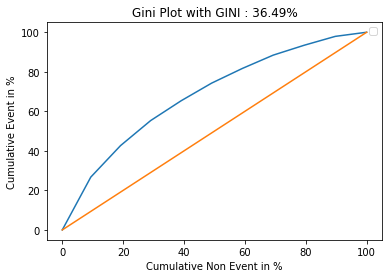

In [26]:
gini_curve

# _THE END_